## Mini-project for LLM course

### Requirements

In [ ]:
!pip install os
!pip install pandas
!pip install dotenv
!pip install random
!pip install openai
!pip install langchain_core
!pip install langchain_ollama
!pip install re
!pip install json
!pip install numpy
!pip install sklearn
!pip install matplotlib

In [32]:
import pandas as pd 
import random
import os 
from dotenv import load_dotenv
from openai import OpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import re
import json

In [3]:
# Load OPENAI API KEY present in the .env file
load_dotenv(".env")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [4]:
def read_xl_wic_file(file_path):
    """
    Reads XL-WiC format txt file and converts to DataFrame.
    Format: target_word \t PoS \t start_idx1 \t end_idx1 \t start_idx2 \t end_idx2 \t example1 \t example2 \t label

    The files follow a tab-separated format:
    target_word <tab> PoS <tab> start-char-index_1 <tab> end-char-index_1 <tab> start-char-index_2 <tab> end-char-index_2 <tab> example_1 <tab> example_2 <tab> label

    - "target_word": the target word which is present in both examples.
    - "PoS": the Part-of-Speech tag of the target word (either "N": noun or "V": verb).
    - "start-index_i": indicates the start char index of target_word in "i"th example. 
    - "end-index_i": indicates the end char index of target_word in "i"th example. 
    - "example_i": corresponds to the "i"th example.
    - "label": can be 1 or 0 depending on whether the intended sense of the target word is the same in both examples (1) or not (0).
    """
    columns = [
        'target_word', 'pos', 
        'start_idx1', 'end_idx1', 
        'start_idx2', 'end_idx2',
        'example1', 'example2', 
        'label'
    ]
    
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            row = [item.strip() for item in line.split('\t')]
            if len(row) == len(columns):
                # Convert indices and label to integers
                row[2:6] = [int(x) for x in row[2:6]]  # Convert all indices
                row[-1] = int(row[-1])  # Convert label
                data.append(row)
    
    return pd.DataFrame(data, columns=columns)

df = read_xl_wic_file('/home/max/Desktop/UNI_Bielefeld/LLM/xlwic_wn_xlingual/xlwic_wn_xlingual/train_en.txt')

In [110]:
def sample_xl_wic_pairs(df, n_samples=100, seed=42):
    """
    Samples random word pairs from XL-WiC dataset and formats them for LLM evaluation
    """
    n_samples_per_label = n_samples // 2
    if seed:
        random.seed(seed)
        np.random.seed(seed)

    # Ensure balanced sampling for each label
    balanced_samples = []
    for label in df['label'].unique():
        label_samples = df[df['label'] == label].sample(n=n_samples_per_label, random_state=seed)
        balanced_samples.append(label_samples)
    combined_samples = pd.concat(balanced_samples).sample(frac=1, random_state=seed)

    formatted_samples = []
    for _, row in combined_samples.iterrows():
        sample_dict = {
            'word': row['target_word'],
            'pos': 'Noun' if row['pos'] == 'N' else 'Verb',
            'sentence1': row['example1'],
            'sentence2': row['example2'],
            'true_label': row['label'],
            'meaning': 'same' if row['label'] == 1 else 'different'
        }
        formatted_samples.append(sample_dict)

    return formatted_samples

In [93]:
samples = sample_xl_wic_pairs(df, n_samples=6)
# Checking how dataset is constructed
for sample in samples:
    print(f"\nTarget word: {sample['word']} ({sample['pos']})")
    print(f"Sentence 1: {sample['sentence1']}")
    print(f"Sentence 2: {sample['sentence2']}")
    print(f"True label: {sample['meaning']} meaning ({sample['true_label']})")


Target word: erase (Verb)
Sentence 1: Please erase the formula on the blackboard -- it is wrong!
Sentence 2: The Turks erased the Armenians in 1915.
True label: different meaning (0)

Target word: play (Verb)
Sentence 1: Play the stock market.
Sentence 2: Who's playing now?
True label: different meaning (0)

Target word: speech (Noun)
Sentence 1: Her speech was barren of southernisms.
Sentence 2: I detected a slight accent in his speech.
True label: same meaning (1)

Target word: point (Noun)
Sentence 1: He missed the point of the joke.
Sentence 2: The cannibal's teeth were filed to sharp points.
True label: different meaning (0)

Target word: tomorrow (Noun)
Sentence 1: Everyone hopes for a better tomorrow.
Sentence 2: Tomorrow's world.
True label: same meaning (1)

Target word: keep (Verb)
Sentence 1: Keep your cool.
Sentence 2: Keep your temper.
True label: same meaning (1)


In [7]:
# eval with OPENAI models
def evaluate_with_llm_OPENAI(samples, model, template):
    client = OpenAI()
    results = []
    
    MODEL_GPT3_5 = "gpt-3.5-turbo-0125"
    MODEL_GTP4 = "gpt-4"

    for sample in samples:
        prompt = f"Sentence 1: {sample['sentence1']}\nSentence 2: {sample['sentence2']}"
        
        completion = client.chat.completions.create(
            model= model,
            messages=[
                {"role": "system", "content": template},
                {"role": "user", "content": prompt}
            ]
        )
        
        llm_response = completion.choices[0].message.content
        results.append({
            'word': sample['word'],
            'true_label': sample['true_label'],
            'llm_response': llm_response
        })
    
    return results

# eval with PHI3 model
def evaluate_with_llm_PHI3(samples):
    MODEL = OllamaLLM(model="phi3")
    TEMPLATE = """You are a helpful assistant. My goal is to check if a target word in a sentence has the same intended sense in another sentence. A target word and two sentences will be passed. Check if the intended sense is the same or not. Label as (1) if the meaning is the same, viceversa (0) for different meaning. In the final response you always add a line where you write the correct Label you think it is, starting in the following way: Label.

{question}"""
    
    results = []
    prompt = ChatPromptTemplate.from_template(TEMPLATE)
    chain = prompt | MODEL
    
    for sample in samples:
        question = f"Sentence 1: {sample['sentence1']}\nSentence 2: {sample['sentence2']}"
        response = chain.invoke({"question": question})
        
        results.append({
            'word': sample['word'],
            'true_label': sample['true_label'],
            'llm_response': response
        })
    
    return results

In [8]:
result_gpt_json = []  
result_phi_json = []  

def save_results_to_json(results, filename):
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            try:
                existing_data = json.load(f)
                if isinstance(existing_data, list):
                    all_results = existing_data
                else:
                    all_results = []
            except json.JSONDecodeError:
                all_results = []
    else:
        all_results = []
    
    for r in results:
        data = {
            'Target Word': r['word'],
            'True Label': str(r['true_label']),
            'LLM Response': r['llm_response']
        }
        all_results.append(data)
    
    with open(filename, 'w') as f:
        json.dump(all_results, f, indent=2)
    
    for r in results:
        print(f"\nWord: {r['word']}")
        print(f"True label: {r['true_label']}")
        print(f"LLM response: {r['llm_response']}")
        print("-------------")

In [9]:
samples = sample_xl_wic_pairs(df)
MODEL_GPT3_5_TURBO = "gpt-3.5-turbo-0125"
MODEL_GPT4 = "gpt-4"
MODEL_GPT4_TURBO = "gpt-4-turbo"
TEMPLATE_V0 = """You are a helpful assistant. My goal is to check if a target word in a sentence has the same intended sense in another sentence. A target word and two sentences will be passed. Check if the intended sense is the same or not. Label as (1) if the meaning is the same, viceversa (0) for different meaning. In the final response you always add a line where you write the correct Label you think it is, starting in the following way: Label."""
TEMPLATE_V1 = """You are a linguistics expert. Determine if a given "target word" has a same meaning in two sentences. Respond with 1 if the meaning of the word is similar or 0 if it is too different. Include your explanation then write in new line "Label: 1 or 0" \n""" 
# results_phi3 = evaluate_with_llm_PHI3(samples)
# save_results_to_json(results_phi3, 'result_phi3_json.json')

In [10]:
# GPT 3.5 TURBO - TEMPLATE V0 AND V1
result_gpt3_5_turbo_template_v0 = evaluate_with_llm_OPENAI(samples, MODEL_GPT3_5_TURBO, TEMPLATE_V0)
result_gpt3_5_turbo_template_v1 = evaluate_with_llm_OPENAI(samples, MODEL_GPT3_5_TURBO, TEMPLATE_V1)
save_results_to_json(result_gpt3_5_turbo_template_v0, 'result_MODEL_GPT3_5_TURBO_TEMPLATE_V0.json')
save_results_to_json(result_gpt3_5_turbo_template_v1, 'result_MODEL_GPT3_5_TURBO_TEMPLATE_V1.json')


Word: day
True label: 1
LLM response: The target word is "day".

It seems that the word "day" has a different intended sense in each sentence. In the first sentence, "day" refers to a specific time period when someone was a successful pianist, while in the second sentence, "day" refers to a historical era in the past.

Label. 0
-------------

Word: grip
True label: 1
LLM response: The word "grip" has a different meaning in the two sentences.

Label: 0
-------------

Word: absence
True label: 1
LLM response: The target word is "absence". In Sentence 1, "absence" refers to the lack of something (explanation), while in Sentence 2, "absence" refers to the state of being away or not present. Therefore, the intended sense of "absence" is different in the two sentences.

Label: 0
-------------

Word: touch
True label: 0
LLM response: The target word is "touch".

These two sentences have different intended senses. 
In the first sentence, "touch" refers to physical contact or sensation. 
In th

In [11]:
# GPT 4 - TEMPLATE V0 AND V1
result_gpt4_template_v0 = evaluate_with_llm_OPENAI(samples, MODEL_GPT4, TEMPLATE_V0)
result_gpt4_template_v1 = evaluate_with_llm_OPENAI(samples, MODEL_GPT4, TEMPLATE_V1)
save_results_to_json(result_gpt4_template_v0, 'result_MODEL_GPT4_TEMPLATE_V0.json')
save_results_to_json(result_gpt4_template_v1, 'result_MODEL_GPT4_TEMPLATE_V1.json')


Word: day
True label: 1
LLM response: The target word is: day

The word "day" in Sentence 1 refers to a particular period of time in someone's life, while in sentence 2 "day" refers to a historical epoch or time period.

Label: 0
-------------

Word: grip
True label: 1
LLM response: Target word: grip

The intended sense of the word "grip" in the first sentence refers to the handle of a sword. In the second sentence, "grip" refers to the rough projections on which one can hold onto, such as in rock climbing. Therefore, the use of "grip" in both sentences does not convey the same meaning. 

Label: 0
-------------

Word: absence
True label: 1
LLM response: Target Word: Absence

In the first sentence, "absence" is used to denote the lack of something, in this case, any explanation. In the second sentence, "absence" refers to the fact of someone not being present and is used in a metaphorical or idiomatic context. Therefore, the two sentences do not use the word "absence" in the same sense

In [12]:
# GPT 4 - TEMPLATE V0 AND V1
result_gpt4_turbo_template_v0 = evaluate_with_llm_OPENAI(samples, MODEL_GPT4_TURBO, TEMPLATE_V0)
result_gpt4_turbo_template_v1 = evaluate_with_llm_OPENAI(samples, MODEL_GPT4_TURBO, TEMPLATE_V1)
save_results_to_json(result_gpt4_turbo_template_v0, 'result_MODEL_GPT4_TURBO_TEMPLATE_V0.json')
save_results_to_json(result_gpt4_turbo_template_v1, 'result_MODEL_GPT4_TURBO_TEMPLATE_V1.json')


Word: day
True label: 1
LLM response: The target word given here is "day/days."

- In Sentence 1, "day" refers to a period in someone's life, suggesting a particular phase or time when he was a successful pianist.
- In Sentence 2, "days" refers to a specific historical period, namely the era of the Roman Empire.

These two uses of "day/days" have different meanings: one is personal and the other historical.

Label: 0
-------------

Word: grip
True label: 1
LLM response: The target word "grip" has different meanings in the two sentences provided. 

- In Sentence 1, "The grip of a sword" refers to the part of the sword designed to be held by the hand.
- In Sentence 2, "There are several good grips on the northern face of this rock" refers to secure hand or footholds used for climbing.

Therefore, the intended sense of "grip" is not the same in both sentences.

Label: 0.
-------------

Word: absence
True label: 1
LLM response: In Sentence 1, the word "absence" refers to the lack of someo

In [14]:
def evaluation_results(results_gpt, title_confusion_matrix):
    plt.style.use('default')
    
    def extract_labels(results):
        true_labels = []
        pred_labels = []
        for r in results:
            true_labels.append(r['true_label'])
            response_lines = r['llm_response'].lower().split('\n')
            pred = None
            for line in response_lines:
                if line.startswith('label'):
                    try:
                        pred = int(line.split()[-1])
                        break
                    except (ValueError, IndexError):
                        continue
            pred_labels.append(pred if pred is not None else 0)
        return true_labels, pred_labels
    
    # Confusion Matrix Heatmap
    plt.figure(figsize=(6, 4))
    true_labels, pred_labels = extract_labels(results_gpt)
    cm = confusion_matrix(true_labels, pred_labels)
    
    plt.imshow(cm, cmap='Blues', interpolation='nearest')
    plt.colorbar()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]),
                    ha="center", va="center", color="black" if cm[i, j] < 30 else "white")
    
    plt.xticks([0, 1], ['Different', 'Same'])
    plt.yticks([0, 1], ['Different', 'Same'])
    plt.title(title_confusion_matrix)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    
    # Distribution of Labels
    plt.figure(figsize=(6, 4))
    
    plt.subplot(1, 2, 1)
    unique, counts = np.unique(true_labels, return_counts=True)
    bars = plt.bar(['Different', 'Same'], counts)
    plt.title('True Labels Distribution')
    plt.ylabel('Count')
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')
    
    plt.subplot(1, 2, 2)
    unique, counts = np.unique(pred_labels, return_counts=True)
    bars = plt.bar(['Different', 'Same'], counts)
    plt.title('Predicted Labels Distribution')
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

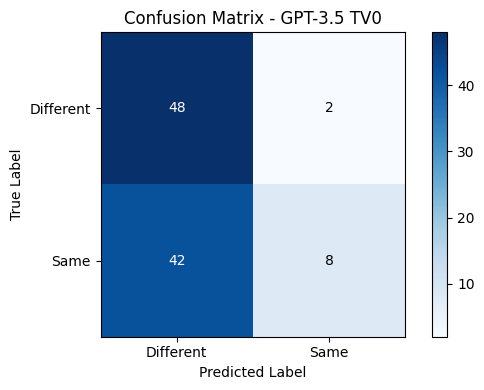

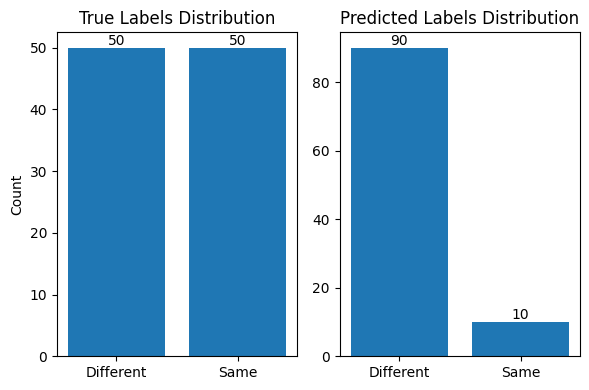

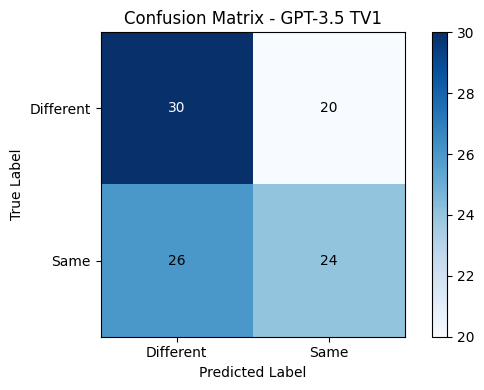

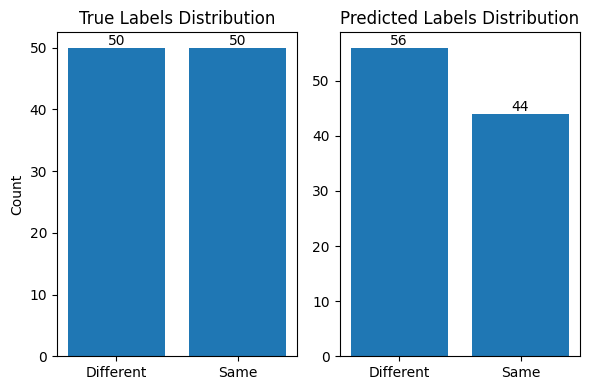

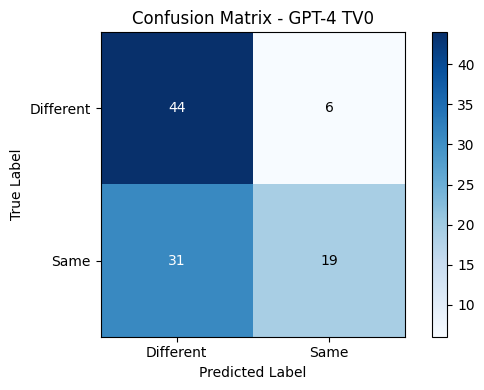

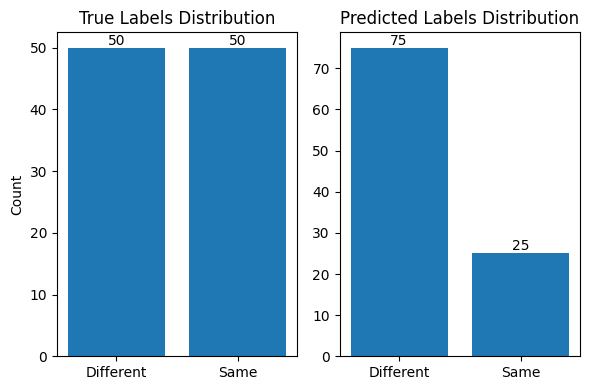

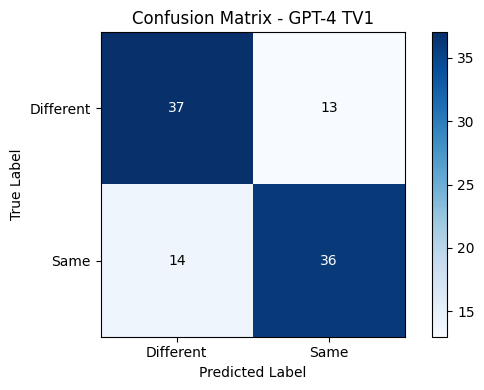

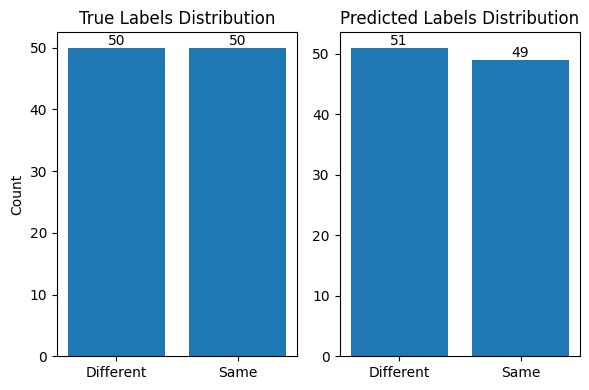

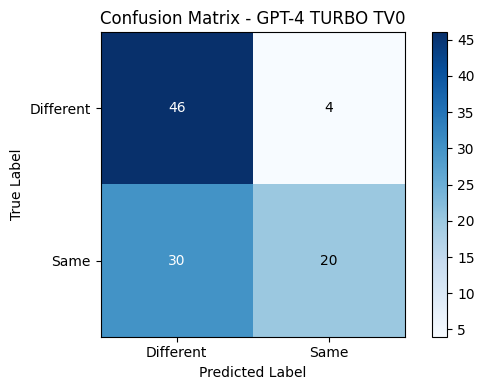

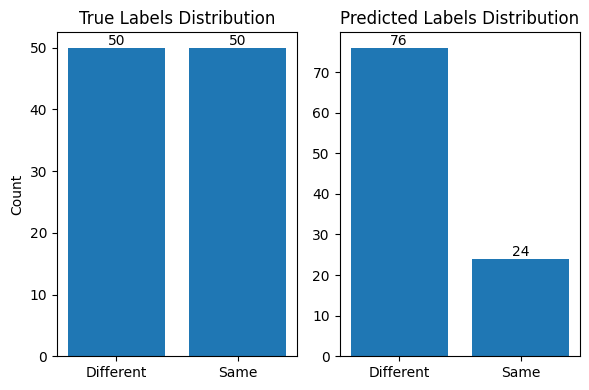

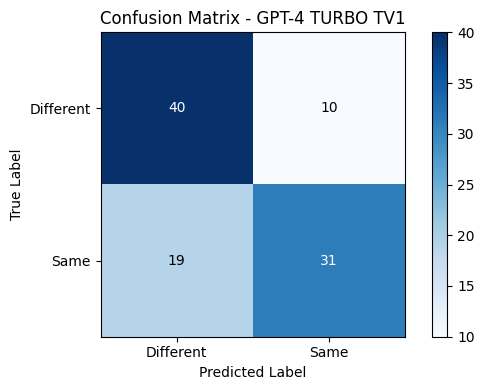

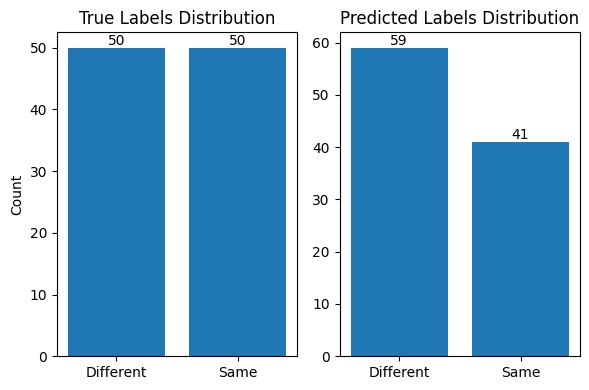

In [15]:
evaluation_results(result_gpt3_5_turbo_template_v0, 'Confusion Matrix - GPT-3.5 TV0')
evaluation_results(result_gpt3_5_turbo_template_v1, 'Confusion Matrix - GPT-3.5 TV1')
evaluation_results(result_gpt4_template_v0, 'Confusion Matrix - GPT-4 TV0')
evaluation_results(result_gpt4_template_v1, 'Confusion Matrix - GPT-4 TV1')
evaluation_results(result_gpt4_turbo_template_v0, 'Confusion Matrix - GPT-4 TURBO TV0')
evaluation_results(result_gpt4_turbo_template_v1, 'Confusion Matrix - GPT-4 TURBO TV1')

In [83]:
results_gpt3_5_v_0 = json.load(open('/home/max/Desktop/UNI_Bielefeld/LLM/Linguistic-perspectives-on-Large-Language-Models/result_MODEL_GPT3_5_TURBO_TEMPLATE_V0.json'))

def extract_pred_labels(results):
        true_labels = []
        pred_labels = []
        for r in results:
            true_labels.append(r['True Label'])
            response_lines = r['LLM Response'].lower().split('\n')
            pred = None
            for line in response_lines:
                if line.startswith('label'):
                    try:
                        pred = int(line.split()[-1])
                        # pred = str(pred)
                        print(pred)
                        break
                    except (ValueError, IndexError):
                        continue
            pred_labels.append(pred if pred is not None else 0)
        return pred_labels

In [84]:
def evaluate_models(true_labels, predictions1, predictions2, template1_name="Template 0", template2_name="Template 1"):
    def calculate_metrics(true_labels, predictions):
        accuracy = accuracy_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions)
        recall = recall_score(true_labels, predictions)
        f1 = f1_score(true_labels, predictions)
        return accuracy, precision, recall, f1

    metrics1 = calculate_metrics(true_labels, predictions1)
    metrics2 = calculate_metrics(true_labels, predictions2)

    cm1 = confusion_matrix(true_labels, predictions1)
    cm2 = confusion_matrix(true_labels, predictions2)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", xticklabels=["Different", "Same"], yticklabels=["Different", "Same"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix: {template1_name}")
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues", xticklabels=["Different", "Same"], yticklabels=["Different", "Same"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix: {template2_name}")
    
    plt.tight_layout()
    plt.show()

    metrics_labels = ["Accuracy", "Precision", "Recall", "F1 Score"]
    metrics_values = np.array([metrics1, metrics2])
    
    x = np.arange(len(metrics_labels))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, metrics_values[0], width, label=template1_name, color="skyblue")
    plt.bar(x + width/2, metrics_values[1], width, label=template2_name, color="salmon")
    plt.xticks(x, metrics_labels)
    plt.ylabel("Score")
    plt.title("Model Evaluation Metrics Comparison")
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"{template1_name} Metrics:")
    print(f"  Accuracy: {metrics1[0]:.2f}, Precision: {metrics1[1]:.2f}, Recall: {metrics1[2]:.2f}, F1 Score: {metrics1[3]:.2f}")
    print(f"{template2_name} Metrics:")
    print(f"  Accuracy: {metrics2[0]:.2f}, Precision: {metrics2[1]:.2f}, Recall: {metrics2[2]:.2f}, F1 Score: {metrics2[3]:.2f}")

    return metrics1, metrics2

In [85]:
# load results from json
results_gpt3_5_v_0 = json.load(open('/home/max/Desktop/UNI_Bielefeld/LLM/Linguistic-perspectives-on-Large-Language-Models/result_MODEL_GPT3_5_TURBO_TEMPLATE_V0.json'))
pred_labels_gpt3_5_v_0 = extract_pred_labels(results_gpt3_5_v_0)
results_gpt3_5_v_1 = json.load(open('/home/max/Desktop/UNI_Bielefeld/LLM/Linguistic-perspectives-on-Large-Language-Models/result_MODEL_GPT3_5_TURBO_TEMPLATE_V1.json'))
pred_labels_gpt3_5_v_1 = extract_pred_labels(results_gpt3_5_v_1)

results_gpt4_v_0 = json.load(open('/home/max/Desktop/UNI_Bielefeld/LLM/Linguistic-perspectives-on-Large-Language-Models/result_MODEL_GPT4_TEMPLATE_V0.json'))
pred_labels_gpt4_v_0 = extract_pred_labels(results_gpt4_v_0)
results_gpt4_v_1 = json.load(open('/home/max/Desktop/UNI_Bielefeld/LLM/Linguistic-perspectives-on-Large-Language-Models/result_MODEL_GPT4_TEMPLATE_V1.json'))
pred_labels_gpt4_v_1 = extract_pred_labels(results_gpt4_v_1)

results_gpt4_turbo_v_0 = json.load(open('/home/max/Desktop/UNI_Bielefeld/LLM/Linguistic-perspectives-on-Large-Language-Models/result_MODEL_GPT4_TURBO_TEMPLATE_V0.json'))
pred_labels_gpt4_turbo_v_0 = extract_pred_labels(results_gpt4_turbo_v_0)
results_gpt4_turbo_v_1 = json.load(open('/home/max/Desktop/UNI_Bielefeld/LLM/Linguistic-perspectives-on-Large-Language-Models/result_MODEL_GPT4_TURBO_TEMPLATE_V1.json'))
pred_labels_gpt4_turbo_v_1 = extract_pred_labels(results_gpt4_turbo_v_1)

true_labels = [int(r['True Label']) for r in results_gpt3_5_v_0]

0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
1
0
0
0
0
0
0
1
0
1
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
1
1
0
1
1
0
0
1
0
0
1
0
0
0
0
1
0
0
1
0
1
0
1
0
0
1
0
0
1
0
0
0
1
1
1
0
1
1
0
1
0
1
0
0
1
1
1
0
1
1
0
1
1
1
0
1
1
0
0
0
1
1
0
0
0
0
0
0
0
1
0
1
0
1
1
1
1
1
0
0
0
0
0
0
0
0
0
1
0
1
1
0
0
1
0
1
0
0
0
0
0
1
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
1
0
1
0
0
1
0
0
0
0
0
0
0
1
0
0
1
0
1
1
0
1
0
1
0
1
0
1
0
1
0
1
1
0
0
0
1
1
0
0
0
0
0
0
0
0
1
0
0
1
0
0
1
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
1
1
0
0
1
0
0
1
0
0
0
0
0
1
0
0
0
1
0
0
1
0
1
0
0
1
0
1
0
1
0
0
0
1
1
0
1
0
1
1
0
1
1
1
0
1
0
0
1
1
1
0
1
1
0
1
0
1
1
0
0
1
1
1
0
1
0
1
1
0
0
1
1
1
1
0
1
0
1
0
0
0
0
0
1
1
1
1
0
1
1
1
1
0
1
0
0
0
0
1
0
1
0
0
0
1
0
1
0
1
0
1
0
0
0
0
1
0
1
1
0
1
0
0
1
1
0
1
1
0
0
1
1
0
0
0
0
0
0
0
0
1
0
0
1
0
1
1
0
1
0
0
0
0
0
1
0
0
0
1
1
0
0
0
0
1
0
1
0
0
0
1
0
0
1
0
0
0
0
0
1
0
0
0
1
0
0
1
0
1
0
0
1
0
1
0
0
0
0
0
0
1
0
1
0
1


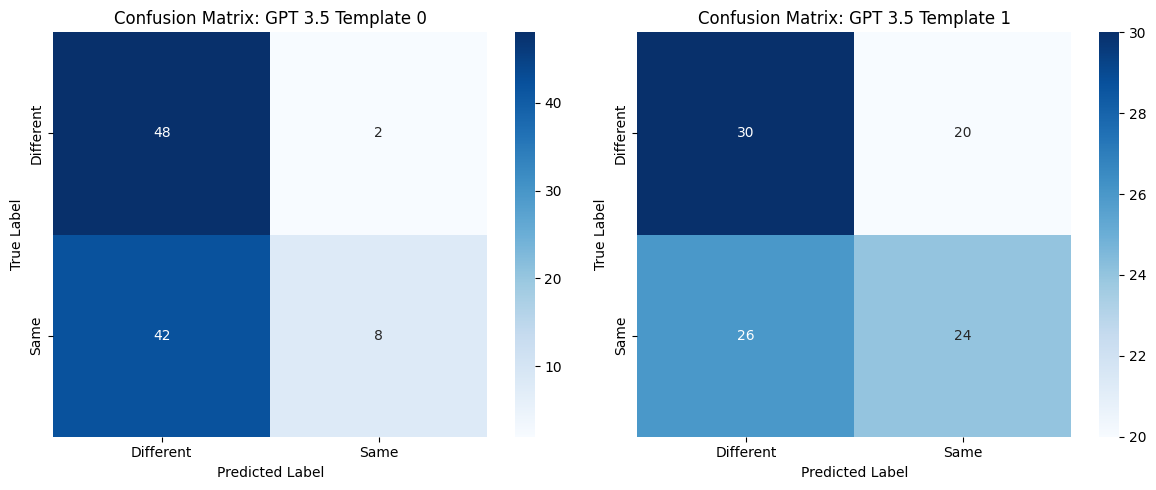

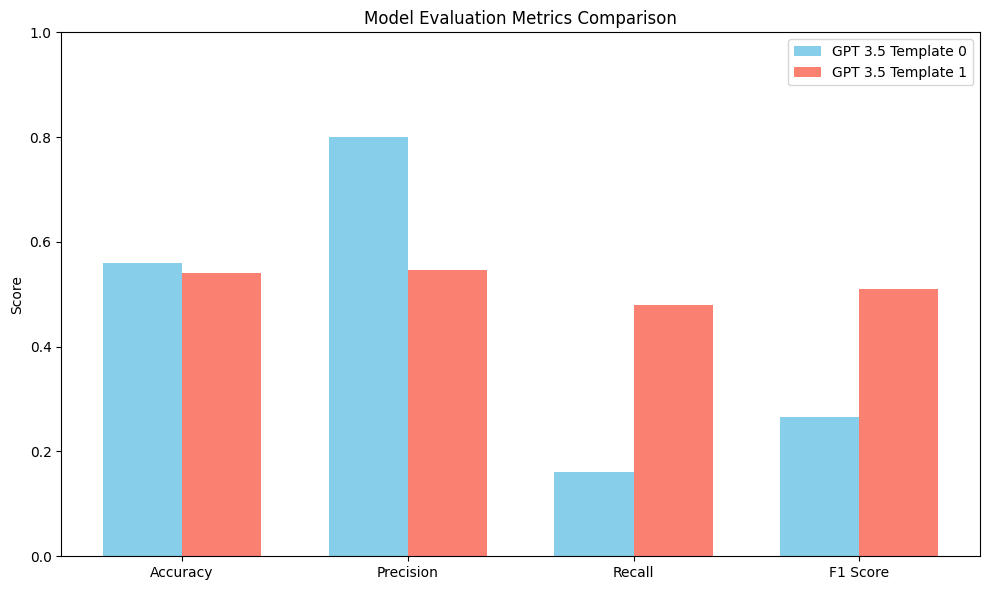

GPT 3.5 Template 0 Metrics:
  Accuracy: 0.56, Precision: 0.80, Recall: 0.16, F1 Score: 0.27
GPT 3.5 Template 1 Metrics:
  Accuracy: 0.54, Precision: 0.55, Recall: 0.48, F1 Score: 0.51


((0.56, 0.8, 0.16, 0.26666666666666666),
 (0.54, 0.5454545454545454, 0.48, 0.5106382978723404))

In [86]:
evaluate_models(true_labels, pred_labels_gpt3_5_v_0, pred_labels_gpt3_5_v_1, template1_name="GPT 3.5 Template 0", template2_name="GPT 3.5 Template 1")

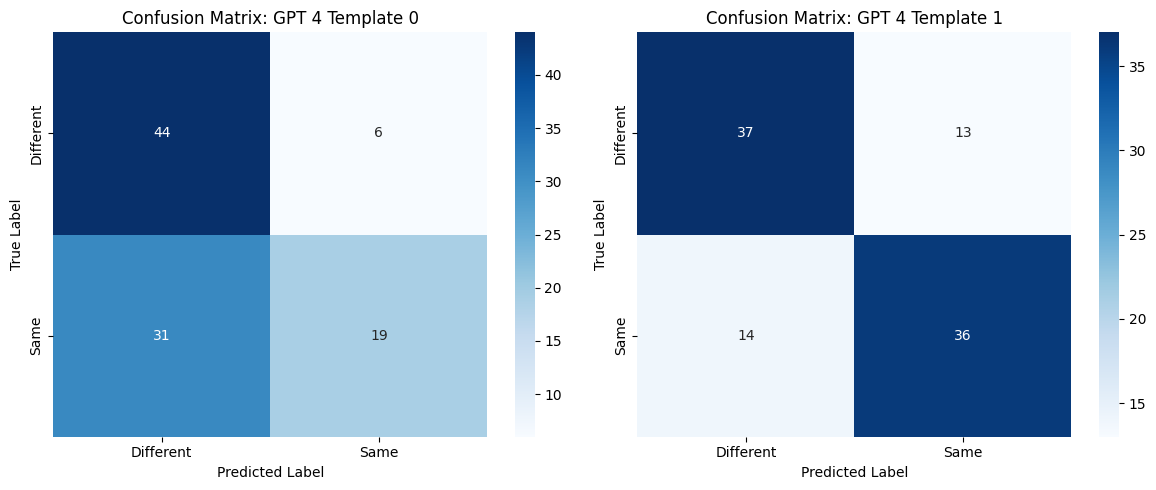

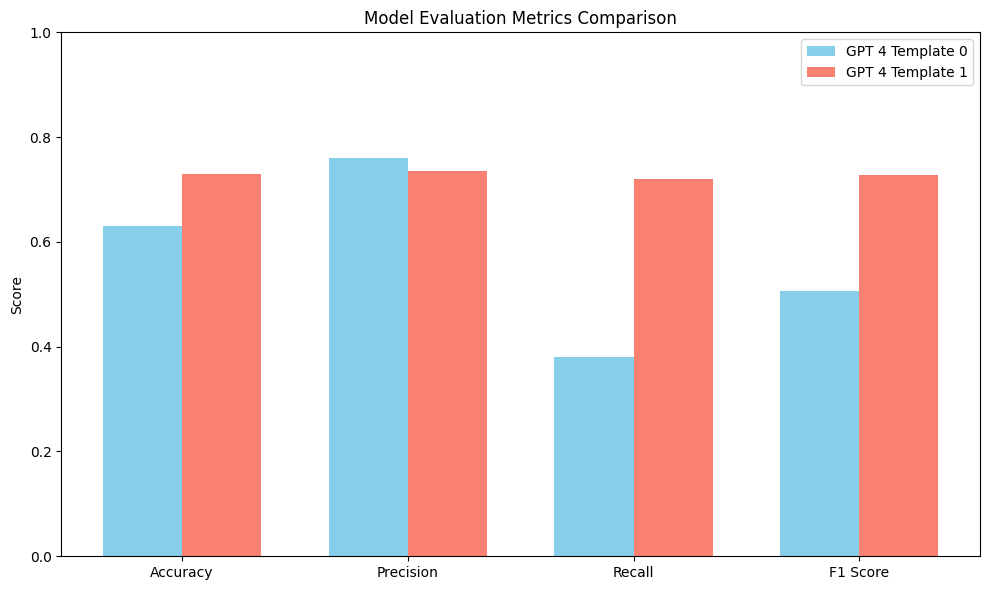

GPT 4 Template 0 Metrics:
  Accuracy: 0.63, Precision: 0.76, Recall: 0.38, F1 Score: 0.51
GPT 4 Template 1 Metrics:
  Accuracy: 0.73, Precision: 0.73, Recall: 0.72, F1 Score: 0.73


((0.63, 0.76, 0.38, 0.5066666666666667),
 (0.73, 0.7346938775510204, 0.72, 0.7272727272727273))

In [87]:
evaluate_models(true_labels, pred_labels_gpt4_v_0, pred_labels_gpt4_v_1, template1_name="GPT 4 Template 0", template2_name="GPT 4 Template 1")

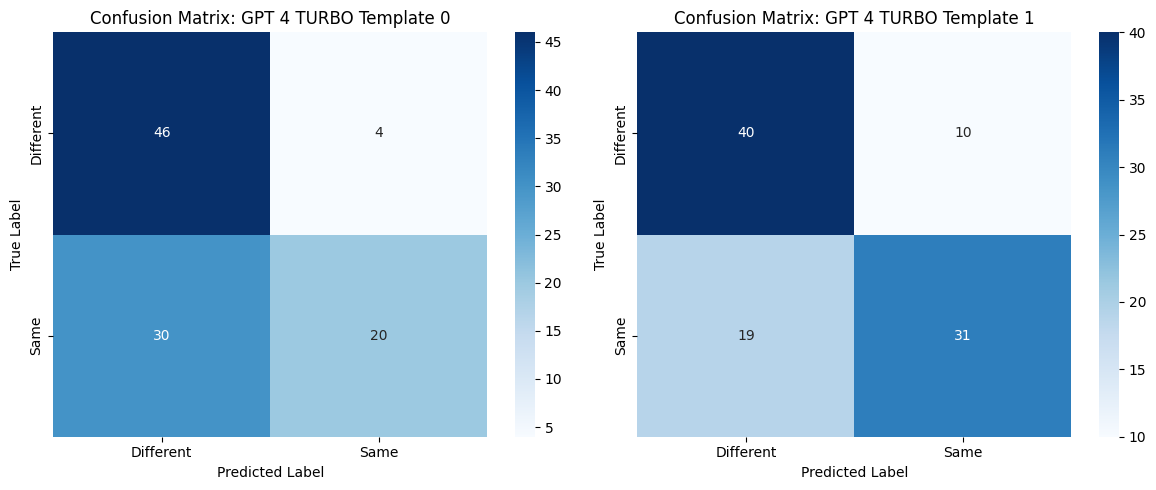

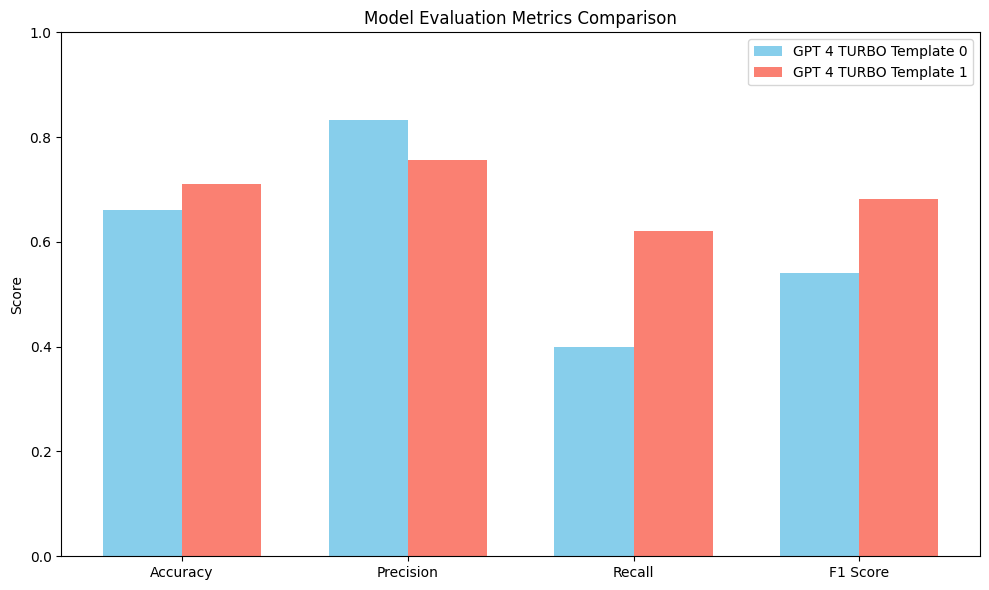

GPT 4 TURBO Template 0 Metrics:
  Accuracy: 0.66, Precision: 0.83, Recall: 0.40, F1 Score: 0.54
GPT 4 TURBO Template 1 Metrics:
  Accuracy: 0.71, Precision: 0.76, Recall: 0.62, F1 Score: 0.68


((0.66, 0.8333333333333334, 0.4, 0.5405405405405406),
 (0.71, 0.7560975609756098, 0.62, 0.6813186813186813))

In [88]:
evaluate_models(true_labels, pred_labels_gpt4_turbo_v_0, pred_labels_gpt4_turbo_v_1, template1_name="GPT 4 TURBO Template 0", template2_name="GPT 4 TURBO Template 1")

### Playing with embeddings

In [60]:
def get_embeddings_for_probing(samples):
    client = OpenAI()
    embeddings_data = []
    
    for sample in samples:
        # get embeddings for each sentence using text-embedding-ada-002
        sentence1_embedding = client.embeddings.create(
            input=sample['sentence1'],
            model="text-embedding-ada-002"
        ).data[0].embedding
        
        sentence2_embedding = client.embeddings.create(
            input=sample['sentence2'],
            model="text-embedding-ada-002"
        ).data[0].embedding
        
        embeddings_data.append({
            'word': sample['word'],
            'embeddings': (sentence1_embedding, sentence2_embedding),
            'label': sample['true_label']   
        })
    
    return embeddings_data

# def get_embeddings_for_words (samples, Model="llama3.2"):
#     from tqdm import tqdm 
#     embeddings_data = []

#     for sample in  tqdm(samples, desc=f"get Embedding: {Model}", smoothing=0):
#         print(f"Processing word: {sample['word']}")
#         sentence1_embedding = client.embeddings.create(model=Model, prompt=sample['sentence1'])["embedding"]
#         sentence2_embedding = ollama.embeddings(model=Model, prompt=sample['sentence2'])["embedding"]
#         embeddings_data.append({
#             'word': sample['word'],
#             'embeddings': (sentence1_embedding, sentence2_embedding),
#             'label': sample['true_label']   
#         })
#     return embeddings_data    

In [ ]:
# Get the embeddings for the dataset samples sentences
gpt3_5_embeddings_data = get_embeddings_for_probing(samples)
json_embeddings = json.dump(gpt3_5_embeddings_data, open('gpt3_5_embeddings_data.json', 'w'), indent=4)

In [129]:
embeddings_data = []
with open("/home/max/Desktop/UNI_Bielefeld/LLM/Linguistic-perspectives-on-Large-Language-Models/gpt_embeddings_data.json", "r") as f:
        data = json.load(f)
        #embeddings_data = [item["embeddings"] for item in data[:10]]
        embeddings_data = data[:5]
        # for i in range(0, 10):
        #         embeddings_data.append(data[:10][i]["embeddings"])
        
embeddings_data

[{'word': 'day',
  'embeddings': [[-0.010437211021780968,
    0.01364720519632101,
    0.04613814875483513,
    -0.02744576521217823,
    -0.0029135900549590588,
    0.02110145427286625,
    -0.022350136190652847,
    0.009491240605711937,
    -0.004342006053775549,
    -0.018843738362193108,
    0.0026345285587012768,
    0.025881759822368622,
    -0.0014441820094361901,
    0.0013590446906164289,
    -0.009611062705516815,
    -0.008444366045296192,
    0.029135899618268013,
    -0.00887320563197136,
    0.00935249775648117,
    -0.024115948006510735,
    -0.019915837794542313,
    -0.011137229390442371,
    -0.01513553224503994,
    -0.002831605961546302,
    -0.015160758048295975,
    0.02483488619327545,
    0.016989635303616524,
    -0.0126255564391613,
    0.004137045703828335,
    -0.016270697116851807,
    0.03324772045016289,
    0.0011493545025587082,
    -0.02618447132408619,
    -0.007422717288136482,
    -0.023346558213233948,
    -0.013470623642206192,
    -0.00980656407

In [121]:
def visualize_word_embeddings_2d(embeddings_data):
    X = np.array([np.concatenate(sample['embeddings']) for sample in embeddings_data])
    labels = np.array([sample['label'] for sample in embeddings_data])
    words = np.array([sample['word'] for sample in embeddings_data])
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    plt.figure(figsize=(12, 8))    
    for i in range(len(X_pca)):
        circle = plt.Circle((X_pca[i, 0], X_pca[i, 1]), 
                          radius=0.2,  # Adjust radius as needed
                          color='red' if labels[i] == 1 else 'blue',
                          alpha=0.2)
        plt.gca().add_patch(circle)
        plt.annotate(words[i], 
                    (X_pca[i, 0], X_pca[i, 1]),
                    fontsize=10,
                    ha='center',
                    va='center')
    
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    plt.title('2D Word Sense Embedding Space')
    
    legend_elements = [Line2D([0], [0], marker='o', color='w',
                            markerfacecolor='red', markersize=10,
                            label='Same Sense'),
                      Line2D([0], [0], marker='o', color='w',
                            markerfacecolor='blue', markersize=10,
                            label='Different Sense')]
    plt.legend(handles=legend_elements)
    plt.gca().set_aspect('equal')
    plt.margins(0.2)
    plt.tight_layout()
    
    return pca, plt.gcf()

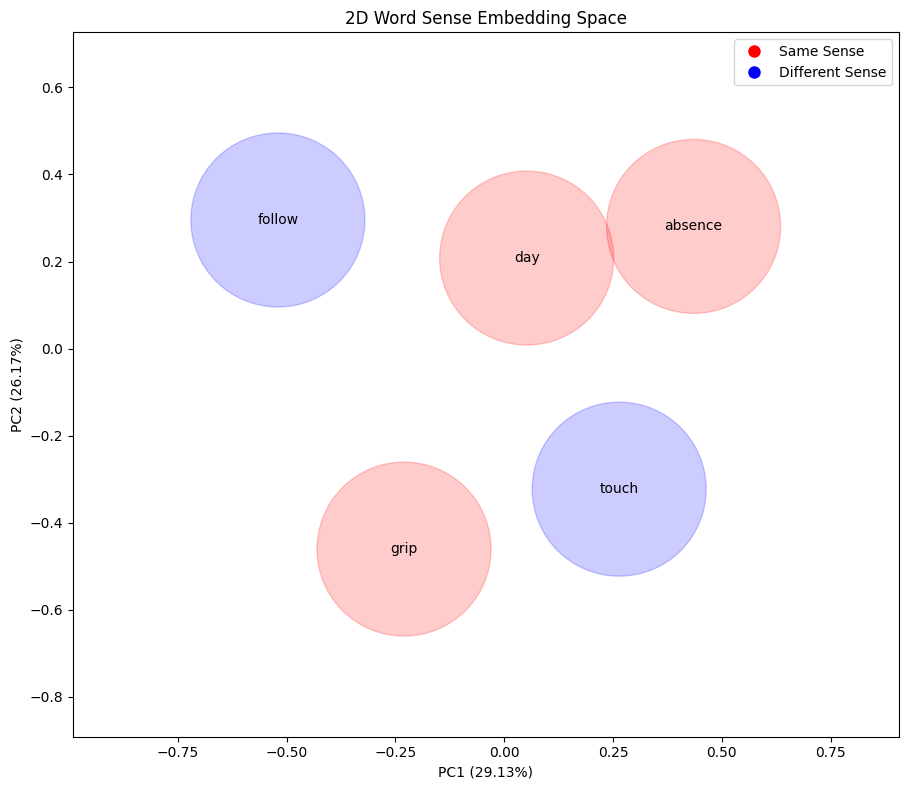

In [131]:
pca_model, fig = visualize_word_embeddings_2d(embeddings_data)
plt.show()

In [123]:
def visualize_word_embeddings_3d_static(embeddings_data, views=[(30, 45), (30, 135), (30, 225), (30, 315)]):
    X = np.array([np.concatenate(sample['embeddings']) for sample in embeddings_data])
    labels = np.array([sample['label'] for sample in embeddings_data])
    words = np.array([sample['word'] for sample in embeddings_data])
    
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)
    
    fig = plt.figure(figsize=(20, 5))
    
    for idx, (elev, azim) in enumerate(views, 1):
        ax = fig.add_subplot(1, len(views), idx, projection='3d')
        
        ax.quiver(0, 0, 0, 1, 0, 0, color='r', alpha=0.5, lw=2)
        ax.quiver(0, 0, 0, 0, 1, 0, color='g', alpha=0.5, lw=2)
        ax.quiver(0, 0, 0, 0, 0, 1, color='b', alpha=0.5, lw=2)
        
        colors = plt.cm.rainbow(np.linspace(0, 1, len(X_pca)))
        for i, (point, word, color) in enumerate(zip(X_pca, words, colors)):
            ax.quiver(0, 0, 0, point[0], point[1], point[2],
                     color=color, alpha=0.6)
            
            ax.text(point[0], point[1], point[2], 
                    word,
                    color=color,
                    fontsize=10)
        
        ax.view_init(elev=elev, azim=azim)
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        ax.set_box_aspect([1,1,1])
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_zlim([-1, 1])        
        ax.grid(True, alpha=0.3)
        ax.set_title(f'View from {azim}°')
    
    plt.suptitle('Word Embeddings Visualization - Multiple Views', y=1.05)
    plt.tight_layout()
    return pca, fig

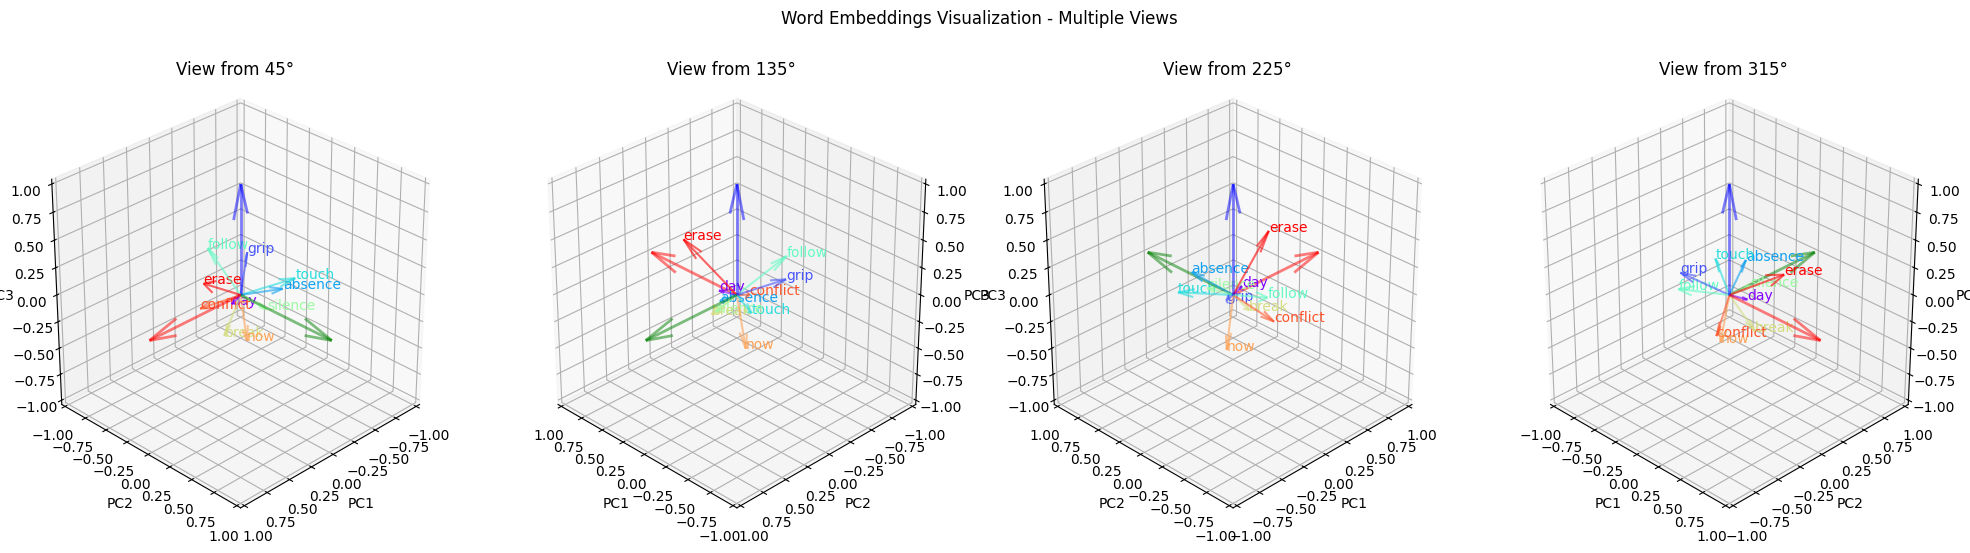

In [124]:
visualize_word_embeddings_3d_static(embeddings_data)
plt.show()

In [125]:
def visualize_sentence_embeddings_comparison(embeddings_data):
    sentences1_embeddings = np.array([sample['embeddings'][0] for sample in embeddings_data])
    sentences2_embeddings = np.array([sample['embeddings'][1] for sample in embeddings_data])
    labels = np.array([sample['label'] for sample in embeddings_data])
    words = np.array([sample['word'] for sample in embeddings_data])
    all_embeddings = np.vstack([sentences1_embeddings, sentences2_embeddings])
    
    pca = PCA(n_components=3)
    all_embeddings_pca = pca.fit_transform(all_embeddings)
    
    n_samples = len(embeddings_data)
    sent1_pca = all_embeddings_pca[:n_samples]
    sent2_pca = all_embeddings_pca[n_samples:]
    
    fig = plt.figure(figsize=(20, 5))
    views = [(30, 45), (30, 135), (30, 225), (30, 315)]
    
    for idx, (elev, azim) in enumerate(views, 1):
        ax = fig.add_subplot(1, len(views), idx, projection='3d')
        
        for i in range(n_samples):
            ax.plot([sent1_pca[i, 0], sent2_pca[i, 0]],
                   [sent1_pca[i, 1], sent2_pca[i, 1]],
                   [sent1_pca[i, 2], sent2_pca[i, 2]],
                   color='red' if labels[i] == 1 else 'blue',
                   alpha=0.5,
                   linestyle='--')
            
            ax.scatter(sent1_pca[i, 0], sent1_pca[i, 1], sent1_pca[i, 2],
                      color='red' if labels[i] == 1 else 'blue',
                      marker='o')
            ax.scatter(sent2_pca[i, 0], sent2_pca[i, 1], sent2_pca[i, 2],
                      color='red' if labels[i] == 1 else 'blue',
                      marker='^')
            ax.text(sent1_pca[i, 0], sent1_pca[i, 1], sent1_pca[i, 2],
                   f'{words[i]}_1', fontsize=8)
            ax.text(sent2_pca[i, 0], sent2_pca[i, 1], sent2_pca[i, 2],
                   f'{words[i]}_2', fontsize=8)
        
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        ax.view_init(elev=elev, azim=azim)
        ax.set_title(f'View from {elev}°, {azim}°')
        
    plt.suptitle('Sentence Embeddings Comparison\nRed: Same Sense, Blue: Different Sense')
    plt.tight_layout()
    
    # legend
    handles = [
        plt.Line2D([0], [0], color='red', label='Same Sense'),
        plt.Line2D([0], [0], color='blue', label='Different Sense'),
        plt.Line2D([0], [0], marker='o', color='gray', label='Sentence 1', linestyle='None'),
        plt.Line2D([0], [0], marker='^', color='gray', label='Sentence 2', linestyle='None')
    ]
    fig.legend(handles=handles, loc='center right')
    
    return pca, fig

In [132]:
def visualize_target_word_embeddings(embeddings_data):
    """
    Visualize embeddings for the target word in both sentences.
    Red for same sense, Blue for different sense.
    """
    target_words = np.array([sample['word'] for sample in embeddings_data])
    labels = np.array([sample['label'] for sample in embeddings_data])
    word1_embeddings = np.array([sample['word'][0] for sample in embeddings_data])
    word2_embeddings = np.array([sample['word'][1] for sample in embeddings_data])
    all_embeddings = np.vstack([word1_embeddings, word2_embeddings])
    
    pca = PCA(n_components=3)
    all_embeddings_pca = pca.fit_transform(all_embeddings)
    n_samples = len(embeddings_data)
    word1_pca = all_embeddings_pca[:n_samples]
    word2_pca = all_embeddings_pca[n_samples:]
    
    fig = plt.figure(figsize=(20, 5))
    views = [(30, 45), (30, 135), (30, 225), (30, 315)]
    
    for idx, (elev, azim) in enumerate(views, 1):
        ax = fig.add_subplot(1, len(views), idx, projection='3d')
        
        for i in range(n_samples):
            color = 'red' if labels[i] == 1 else 'blue'
            
            ax.plot([word1_pca[i, 0], word2_pca[i, 0]],
                   [word1_pca[i, 1], word2_pca[i, 1]],
                   [word1_pca[i, 2], word2_pca[i, 2]],
                   color=color, alpha=0.5, linestyle='--')
            
            ax.scatter(word1_pca[i, 0], word1_pca[i, 1], word1_pca[i, 2],
                      color=color, marker='o')
            ax.scatter(word2_pca[i, 0], word2_pca[i, 1], word2_pca[i, 2],
                      color=color, marker='^')
            ax.text(word1_pca[i, 0], word1_pca[i, 1], word1_pca[i, 2],
                   f'{target_words[i]}_ctx1', fontsize=8)
            ax.text(word2_pca[i, 0], word2_pca[i, 1], word2_pca[i, 2],
                   f'{target_words[i]}_ctx2', fontsize=8)
        
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        ax.view_init(elev=elev, azim=azim)
        ax.set_title(f'View from {elev}°, {azim}°')
        ax.set_box_aspect([1,1,1])
        
    plt.suptitle('Target Word Embeddings in Different Contexts\nRed: Same Sense, Blue: Different Sense')
    
    # legend
    handles = [
        plt.Line2D([0], [0], color='red', label='Same Sense'),
        plt.Line2D([0], [0], color='blue', label='Different Sense'),
        plt.Line2D([0], [0], marker='o', color='gray', label='Context 1', linestyle='None'),
        plt.Line2D([0], [0], marker='^', color='gray', label='Context 2', linestyle='None')
    ]
    fig.legend(handles=handles, loc='center right')
    
    plt.tight_layout()
    return pca, fig

ValueError: could not convert string to float: 'd'

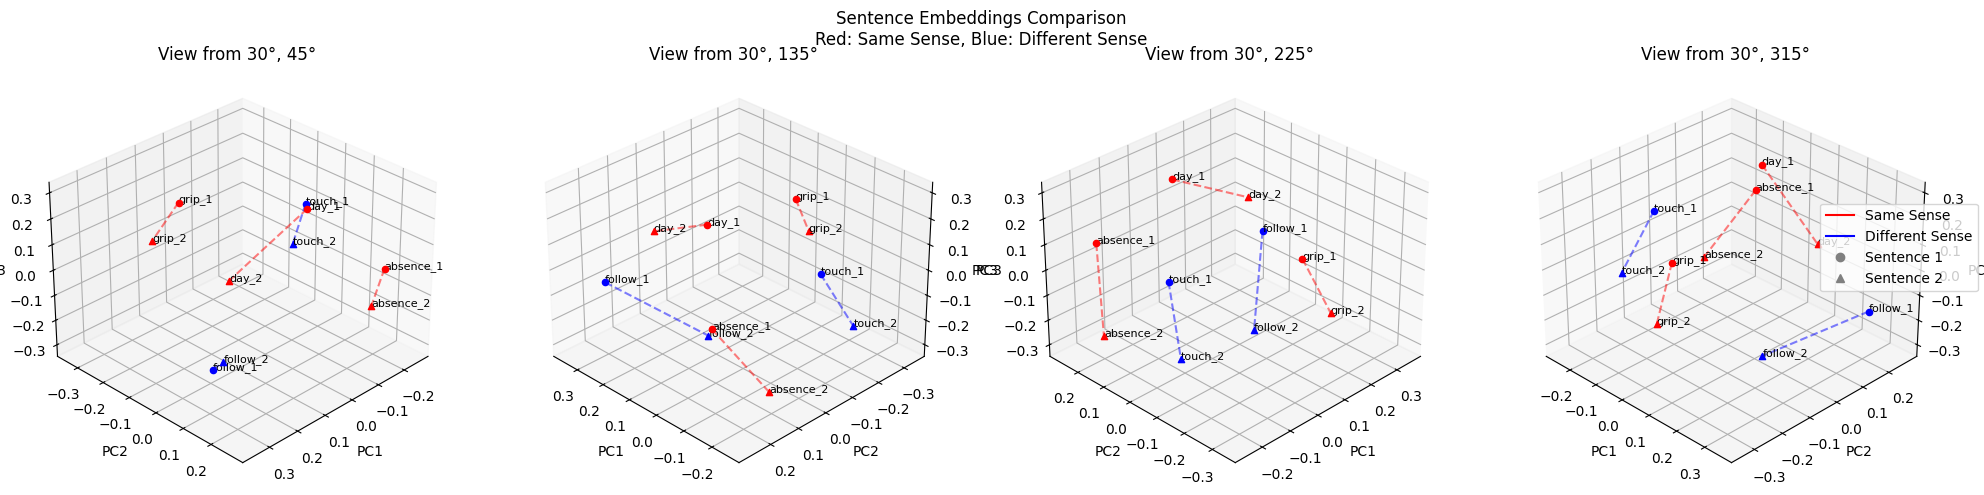

In [133]:
pca_model_sentences, fig_sentences = visualize_sentence_embeddings_comparison(embeddings_data)
pca_model_target_word, fig_target_word = visualize_target_word_embeddings(embeddings_data)
plt.show()

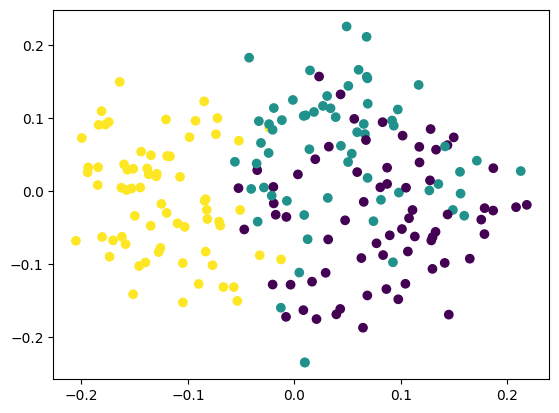

In [ ]:
def analyze_sense_clusters(embeddings_data):
    
    all_embeddings = np.vstack([emb for sample in embeddings_data for emb in sample['embeddings']])
    kmeans = KMeans(n_clusters=3)
    clusters = kmeans.fit_predict(all_embeddings)
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(all_embeddings)
    
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                c=clusters, cmap='viridis')
analyze_sense_clusters(embeddings_data)